# Problema del titanic espacial

Bienvenido al año 2912, donde se requieren tus habilidades como científico de datos para resolver un misterio cósmico. Hemos recibido una transmisión desde un lugar a 4 años luz y parece que hay problemas.

La nave espacial Titanic es un transatlántico interestelar lanzado hace un mes. Con casi 13000 pasajeros a bordo, el buque partió en su viaje inagurual transportando emigrandes de nuestro sistema solar a tres nuevos exoplanetas habitables que orbitan estrellas cercanas.

Mientras rodeaba Alpha Centauri en rutra a su primer destino- el caluroso 55 Cancri E- la nave Titanic chocó con una anomalía espaciotemporal oculta dentro de una nube de polvo. Tristemente, una nave con el mismo nombre tuvo un destino similar hace 1000 años. Aunque la nave quedó intacta, casi la mitad de sus pasajeros fueron transportados a una dimensión alterna.

Para ayudar en el rescate de la tripulación y los pasajeros perdidos, se te pide que predigas cuáles pasajeros fueron transportados por la anomalía usando unos datos recuperados del sistema computacional dañado de la nave espacial.

## Evaluación de Kaggle
Las entregas serán evaluadas usando su exactitud de clasificación (*accuracy*): el porcentaje de etiquetas predichas que se clasificaron correctamente.


## Formato de entrega
El formato de entrega para la competición es un archivo csv con el siguiente formato
```
PassengerId,Transported
0013_01,False
0018_01,False
0019_01,False
0021_01,False
etc.
```

## 1. Definición del problema

> Prediga cuales pasajeros deben ser transportados a una dimensión alternativa.

Este tipo de problema corresponde al de *clasificación*.

## 2. Datos

Los datos fueron tomados de [Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/overview). Existen 2 tipos de datasets separados desde el inicio: *train.csv* y *test.csv* . En *train.csv* hay $8693$ registros, $13$ atributos y $1$ objetivo. De manera similar en *test.csv* hay $4277$ registros y $13$ atributos.

## 3. Evaluación

En la tabla de posiciones en Kaggle para este reto, los primeros 100 mejores participantes tienen un *accuracy* de más de 0.809, por lo que se establece como meta superar esta marca.

> **Objetivo**: Lograr una exactitud de más del 80% al determinar si un pasajero fue transportado a otra dimensión.


## 4. Análisis Exploratorio de los datos

Descripciones de los archivos y los campos de cada uno

* train.csv - Se usarán los registros personales de cerca de dos tercios de los pasajeros (~8700).
    * PassengerId - Un identificador único para cada pasajero. Cada Id toma la forma gggg_pp donde gggg indica un grupo con el que estaba viajando el pasajero y pp es su número dentro del grupo. En la mayoría de casos, las personas en un grupo son frecuentemente familiares, pero esto no sucede siempre.
    * HomePlanet - El planeta desde el cual partió el pasajero, siendo normalmente su planeta de residencia permanente.
    * CryoSleep - Indica si el pasajero fue elegido para estar puesto en animación suspendida por la duración del viaje. Los pasajeros en criosueño están confinados en sus cabinas.
    * Cabin - El número de la cabina donde se aloja el pasajero. Tiene la forma cubierta/número/lado, donde un lado puede ser o P para babor (de *Port*: la izquierda)o S para estribor (de *Starboard*: La derecha).
    * Destination - El planeta donde desembarcaría el pasajero.
    * Age - La edad del pasajero
    * VIP - Indica si el pasajero pagó por un servicio especial VIP durante el viaje.
    * RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Cantidad que el pasajero facturó en cada uno de los muchos servicios de lujo de la nave espacial Titanic.
    * Name - El nombre y apellido del pasajero.
    * Transported - Indica si el pasajero fue transportado a otra dimensión. **Esta es la columna objetivo**.
* test.csv - Registro personal para el tercio restante de los pasajeros (~4300) será usado como datos de prueba. El objetivo es predecir el valor para la columna *Transported* asociada a los pasajeros en este conjunto de datos.
* sample_submission.csv - Un archivo de entrega en el formato correcto.
    * PassengerId - Id para cada pasajero en el conjunto de pruebas.
    * Transported - El objetivo. Para cada pasajero, prediga si es *True* o *False*.

In [2]:
#Instale sweetviz y catboost
#!pip install sweetviz
#!pip install catboost
#!pip install category_encoders

Para comenzar, carguemos todas las bibliotecas que vamos a usar:

In [3]:
#Bibliotecas básicas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Biblioteca que genera un reporte para el EDA
import sweetviz


from sklearn.decomposition import PCA
#Biblioteca para obtener la información mutua entre las características
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

#Biblioteca para hacer una validación cruzada
from sklearn.model_selection import cross_val_score

#Bibliotecas relacionadas con las transformaciones de columnas
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from category_encoders import MEstimateEncoder

#Bibliotecas para el modelamiento
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

#Biblioteca para hacer la agrupación por las k-medias
from sklearn.cluster import KMeans

Definimos ahora una serie de funciones que nos permitirán hacer un análisis de manera más organizada:

In [4]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores_classification(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def make_mi_scores_regression(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100,figsize=(8,5))
    scores=scores.sort_values(ascending=True)
    width= np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Information Scores");
    

def plot_pca_box_diagram(X_pca):
    sns.catplot(
      y='value',
      col='variable',
      data=X_pca.melt(),
      kind='boxen',
      sharey=False,
      col_wrap=2
    );

def eliminar_valores_atipicos_pca(train,num):
  """
  Train: Conjunto de entrenamiento, incluye la variable objetivo
  num:Número de valores extremos que se tomará para cada componente principal por arriba y por debajo
  """
  X=train.copy()
  num_features=list(X.select_dtypes("float64").columns)
  def encontrar_valores_atipicos_por_componente(X,X_pca,component, num):
    idx=X_pca[component].sort_values(ascending=False).index
    X_aux=X.copy()
    X_aux.set_index(idx, inplace=True)
    return (X_aux.head(num), X_aux.tail(num))
  lista_va_sup=list()
  lista_va_inf=list()
  _, X_pca, _ = apply_pca(X[num_features], standardize=True)
  plot_pca_box_diagram(X_pca)
  for pc in list(X_pca.columns):
    va=encontrar_valores_atipicos_por_componente(X,X_pca,pc,num)
    lista_va_sup.append(va[0])
    lista_va_inf.append(va[1])
  valores_atipicos=pd.concat(lista_va_sup+lista_va_inf).reset_index().drop_duplicates(subset='index').set_index('index')
  return train.reset_index().drop(list(valores_atipicos.index),axis=0).set_index('index')

Carguemos los datos de nuestro proyecto:

In [5]:
#Vamos a definir una función para cargar los datos, puede sernos útil si queremos volver a cargar los datos más adelante
def loadData(train_path,test_path):
     return (pd.read_csv(train_path),pd.read_csv(test_path))
train ,test = loadData('train.csv','test.csv') 

# Tratamiento inicial de algunos datos

Debido a que las características `PassengerId`, `Cabin` y `Name` son cadenas de textos que contienen información que podría ser importante, es prudente separarlas en nuevas características.
Para la característica `PassengerId` basta con cortar la cadena de caracteres usando el método `split('_')`. De aquí se obtendrán las nuevas características `Group` y `NumInGroup`.
De manera similar cortaremos la característica `Cabin` por el caracter /. Se obtendrán las características `CabinDeck` `CabinNumber` y `CabinSide`. 
Por último, podríamos hacer un análisis a los nombres de las personas para determinar su sexo. Primero separaremos el nombre en `FirstName` y `LastName`. Con `FirstName` y  el paquete `NLTK` obtendremos el género de la persona. La característica `LastName` la utilizaremos junto a la característica `Group` para crear una nueva que nos diga si esta persona viaja en familia o no, dado que en la descripción se menciona que en la mayoría de casos, las personas en un grupo son frecuentemente familiares, pero esto no sucede siempre. Supondremos que las personas que viajan en familia tienen el mismo apellido. Esta característica se llamará `NumFamMem` y será el número de personas que comparten el mismo apellido dentro de su grupo.

Comencemos instalando nltk y luego entrenando el clasificador.

In [6]:
!pip install nltk

In [7]:
# importing libraries
## Código tomado de https://www.geeksforgeeks.org/python-gender-identification-by-name-using-nltk/

import random

import nltk
nltk.download('names')
from nltk.corpus import names

def gender_features(word):
    return {'last_letter':word[-1]}

# preparing a list of examples and corresponding class labels.
labeled_names = ([(name, 'male') for name in names.words('male.txt')]+
             [(name, 'female') for name in names.words('female.txt')])
  
random.shuffle(labeled_names)
  
# we use the feature extractor to process the names data.
featuresets = [(gender_features(n), gender) 
               for (n, gender)in labeled_names]
  
# Divide the resulting list of feature
# sets into a training set and a test set.
train_set, test_set = featuresets[500:], featuresets[:500]
  
# The training set is used to 
# train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(train_set)
  
#print(classifier.classify(gender_features('Darío')))
  
# output should be 'male'
#print(nltk.classify.accuracy(classifier, train_set))
  
# it shows accuracy of our classifier and 
# train_set. which must be more than 99 % 
# classifier.show_most_informative_features(10)

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\ddfa9\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Ahora definimos la transformación inicial de los datos, esta se aplicará tanto a los datos de entrenamiento como a los de prueba.

In [8]:
def transformacion_inicial_datos(dataframe):
    df = dataframe.copy()
    
    df['NumInGroup']=df.PassengerId.replace(to_replace='^\d{4}_',value='',regex=True).apply(lambda x: float(x))
    df['Group']=df.PassengerId.replace(to_replace='_\d{2}$',value='',regex=True).apply(lambda x: float(x))

    df['CabinDeck']=df.Cabin.replace(to_replace='/\w*',value='',regex=True)
    df['CabinNumber']=df.Cabin.replace(to_replace='[^\d]',value='',regex=True).apply(lambda x: float(x))
    df['CabinSide']=df.Cabin.replace(to_replace='^\w/\w*/',value='',regex=True)

    #Descartamos la columna name
    aux=df['Name'].str.split(' ', expand=True)
    aux.columns=['FirstName','LastName']
    df=df.join(aux)
    
    df['Gender']=df['FirstName'].apply(lambda nombre: classifier.classify(gender_features(str(nombre))) if str(nombre)!='nan' else nombre)
    df.drop(['PassengerId','Cabin','Name','FirstName','LastName'],axis=1,inplace=True)
    
    #df['CryoSleep']=df['CryoSleep'].apply(lambda x: 1.0 if x else 0.0)
    #df['Transported']=df['Transported'].apply(lambda x: 1.0 if x else 0.0)
    df['VIP']=df['VIP'].apply(lambda x: 1.0 if x else 0.0)
    
    #print(df.groupby(['Group'])['LastName'].transform(pd.Series.count))
    # a eliminar 'Group','CabinNumber','CabinSide'
    #df['NumFamMem']=df.groupby(['Group','LastName','HomePlanet','Destination'])['LastName'].transform('count')
    
    #df['NumInGroupIs3']=df['NumInGroup'].apply(lambda x: x==3)
    
    #df['ShareCabinDeckAndNumber']=df.groupby(['CabinDeck','CabinNumber'])['CabinNumber'].transform('count')
    #df['SleepAlone']=df.groupby(['CabinDeck','CabinNumber','CabinSide'])['CabinSide'].transform('count')
    
    #df.drop(['PassengerId','Cabin','Name','FirstName','LastName','Group','CabinNumber','CabinSide'],axis=1,inplace=True)

    return df

Antes de iniciar un análisis, aseguremonos de que hacemos la separación de los datos de entrenamiento. Como no tenemos ninguna manera de verificar el conjunto de prueba, a parte de enviar el resultado a Kaggle, vamos a partir el conjunto de entrenamiento en una parte de entrenamiento y otra de validación. En este caso usaremos un 25% del tamaño. 

In [9]:
from sklearn.model_selection import train_test_split

train2=transformacion_inicial_datos(train)
train_df, valid_df,_,_= train_test_split(train2,train2,test_size=0.25,random_state=0)
X_train=train_df.copy()
y_train=X_train.pop('Transported')
X_valid=valid_df.copy()
y_valid=X_valid.pop('Transported')
X_valid

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,NumInGroup,Group,CabinDeck,CabinNumber,CabinSide,Gender
3601,Earth,False,55 Cancri e,16.0,0.0,0.0,0.0,623.0,40.0,209.0,5.0,3868.0,F,731.0,S,female
6057,Earth,NaN,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6405.0,NaN,NaN,NaN,female
2797,Earth,False,TRAPPIST-1e,31.0,0.0,517.0,1.0,301.0,60.0,4.0,1.0,3021.0,G,476.0,S,female
7110,Earth,False,55 Cancri e,14.0,0.0,653.0,0.0,4.0,0.0,0.0,1.0,7578.0,F,1572.0,P,female
8579,Europa,True,55 Cancri e,30.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,9158.0,B,298.0,P,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,Earth,False,TRAPPIST-1e,26.0,0.0,401.0,0.0,693.0,62.0,0.0,1.0,1979.0,F,376.0,S,female
4160,Europa,False,TRAPPIST-1e,38.0,0.0,2.0,114.0,771.0,3094.0,448.0,1.0,4446.0,B,175.0,S,male
6477,Mars,True,TRAPPIST-1e,33.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6832.0,F,1421.0,P,male
3641,Earth,True,TRAPPIST-1e,33.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3915.0,G,641.0,S,female


Nos gustaría analizar la columna **Transported**. Hagamos una breve exploración usando **Sweetviz**,

In [10]:
my_report = sweetviz.compare([train_df, "Train"], [valid_df, "Valid"], "Transported")
#my_report = sweetviz.analyze([eliminar_valores_atipicos_pca(train_df.dropna(axis=0),7), "Train"], "Transported")

                                             |                                             | [  0%]   00:00 ->…

D:\DataScience\Spacial_titanic_project\env\lib\site-packages\sweetviz\graph.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figure.savefig(as_raw_bytes, format='png', transparent=True)


Report Report_viewable.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



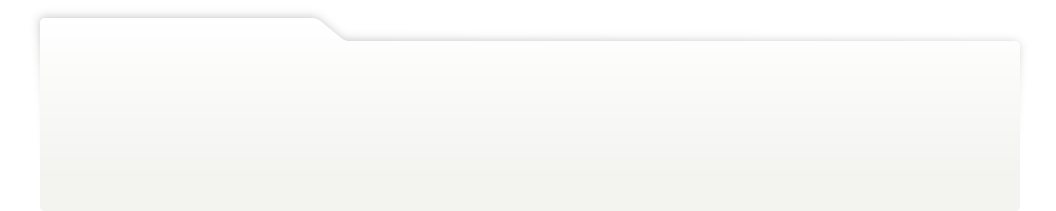
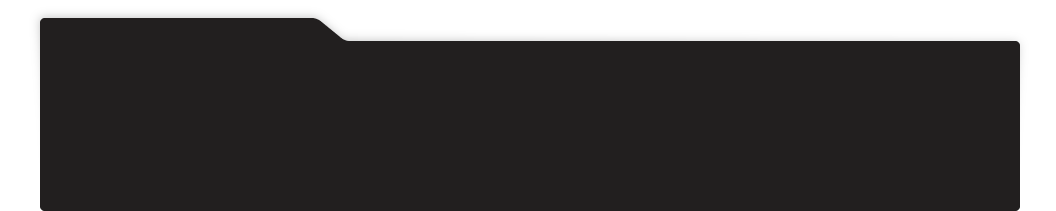
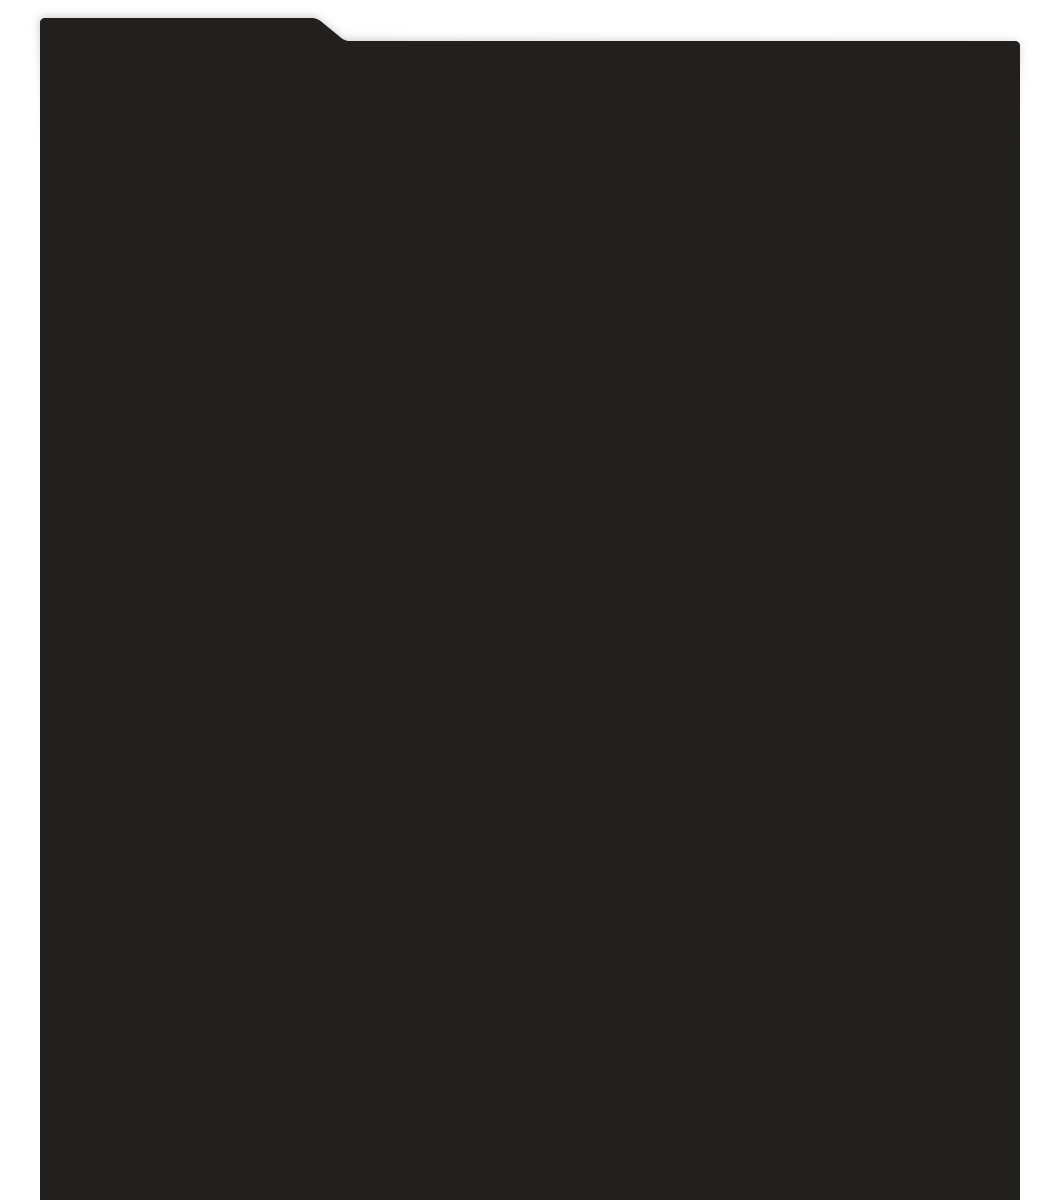
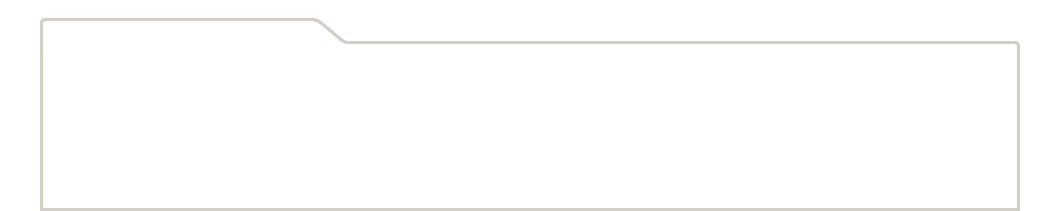
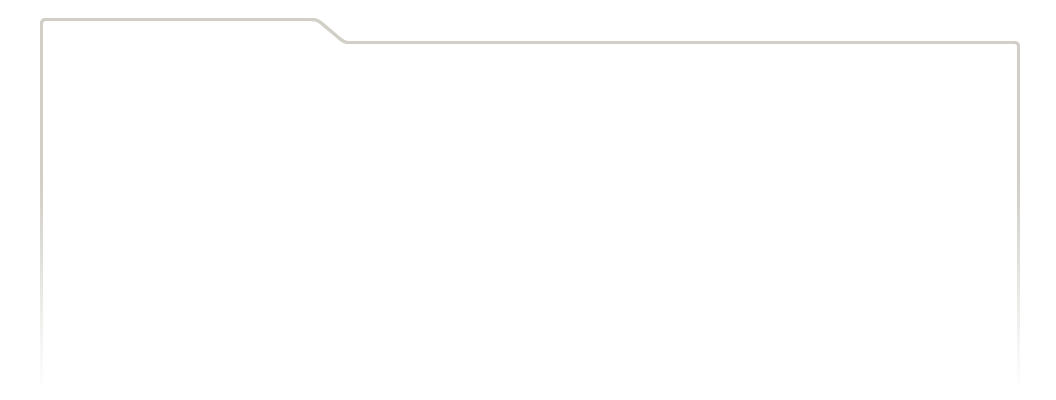
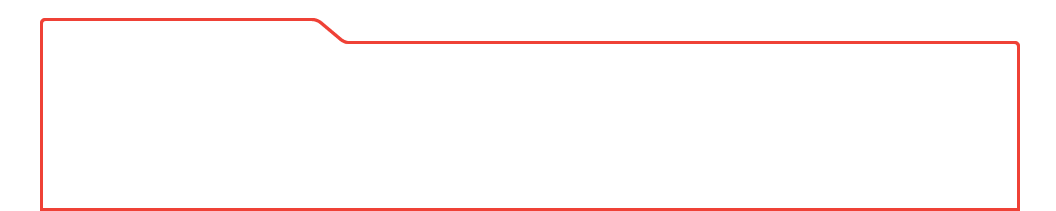
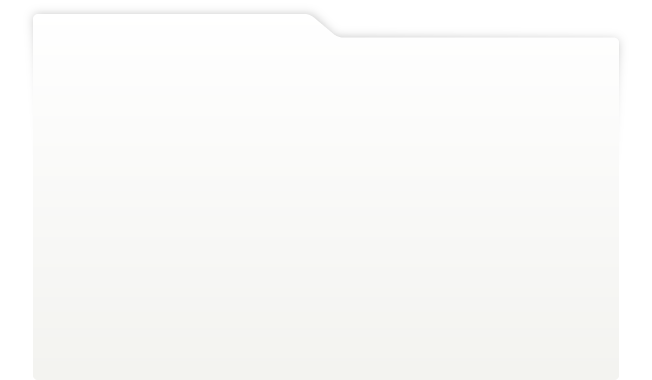
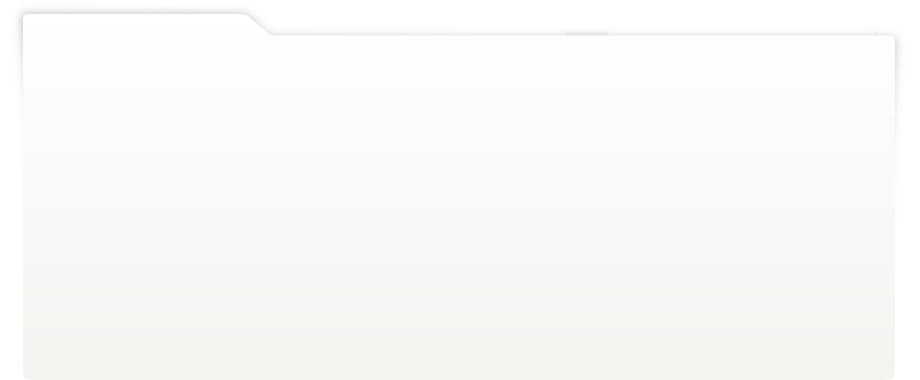
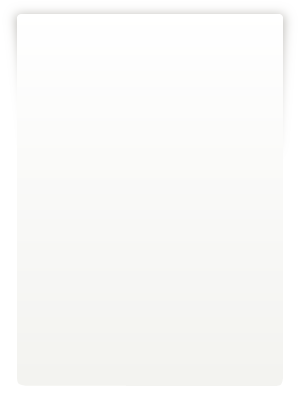
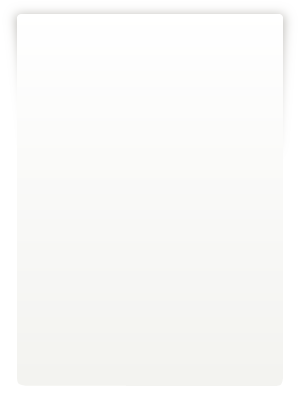
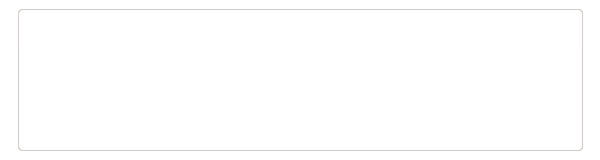
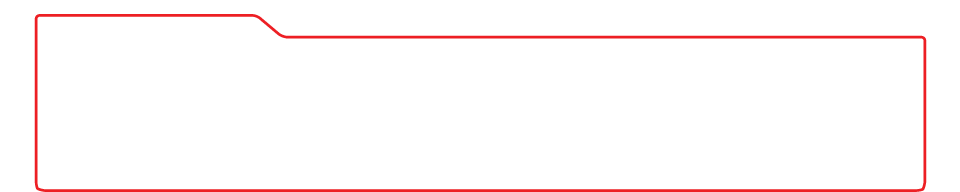
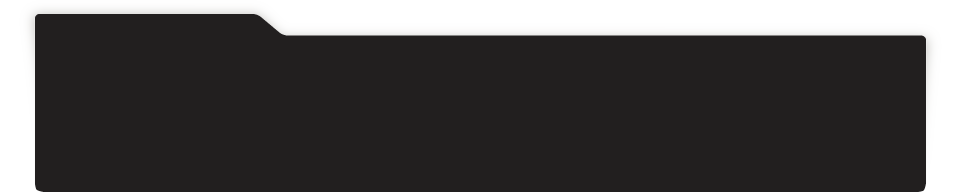
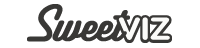
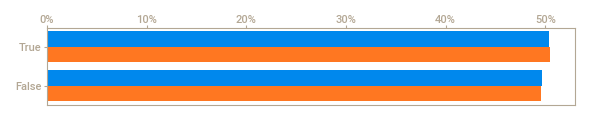
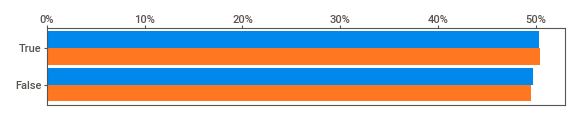
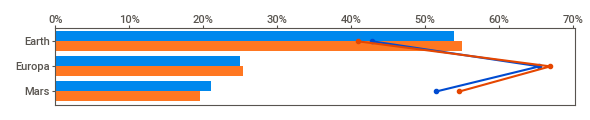
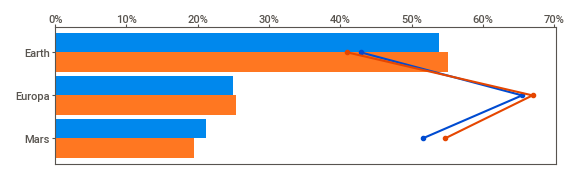
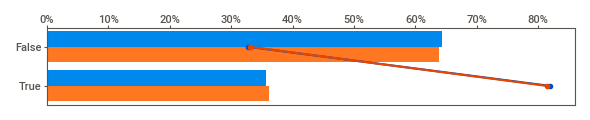
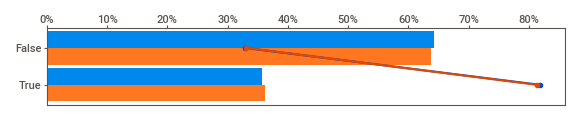
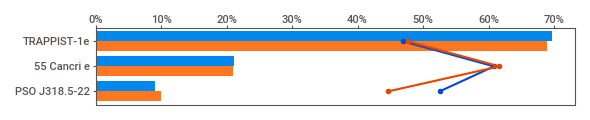
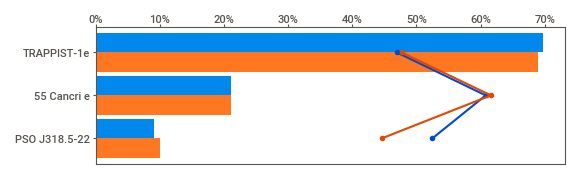
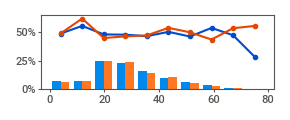
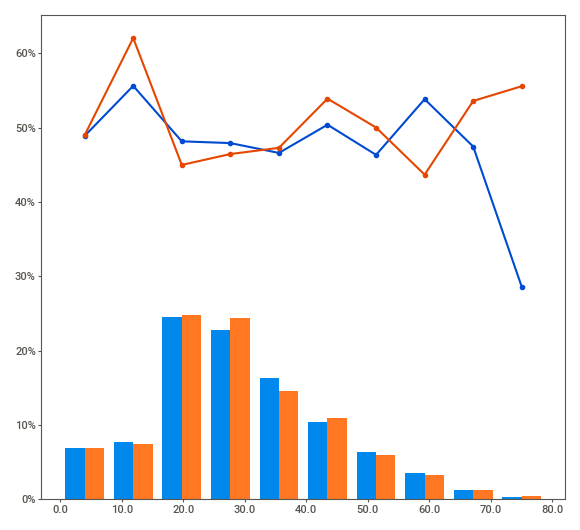
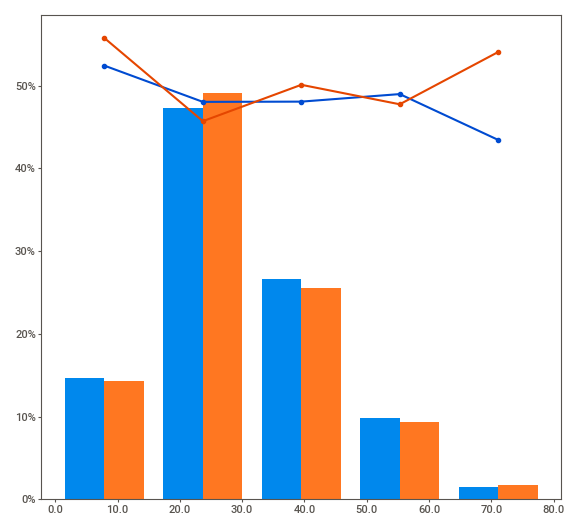
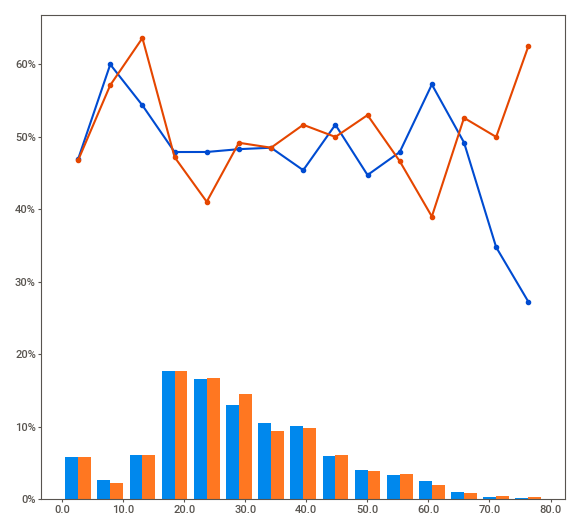
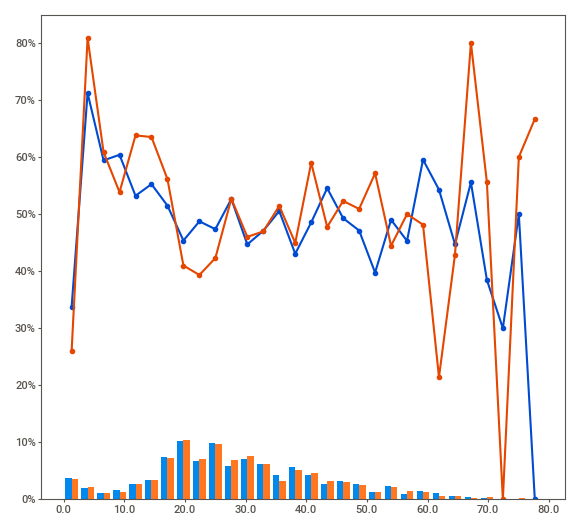
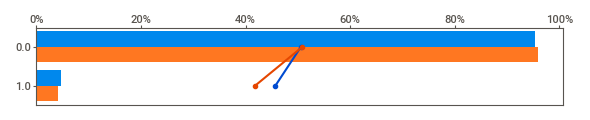
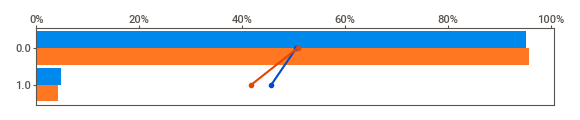
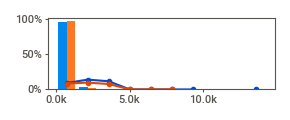
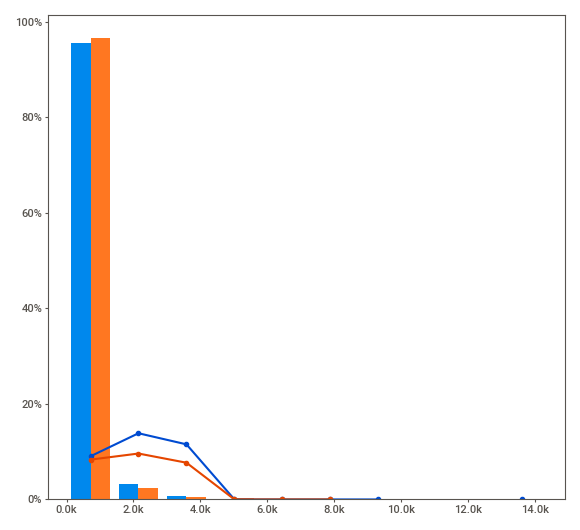
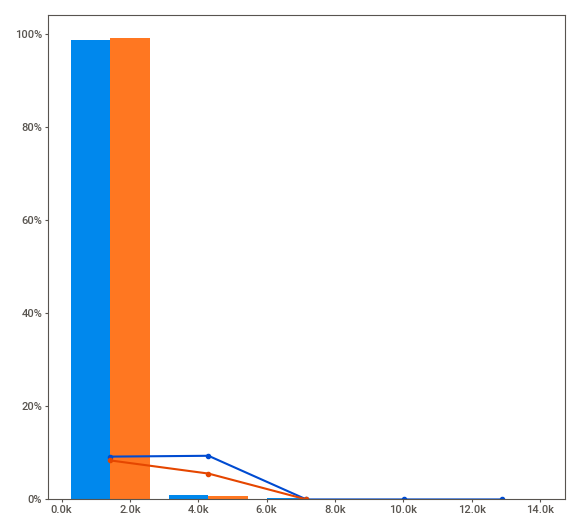
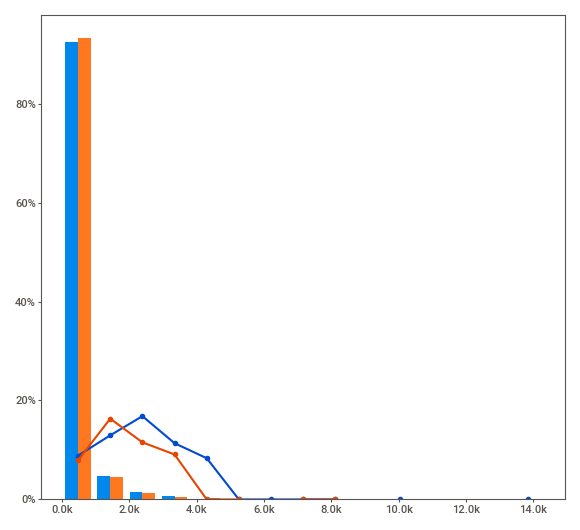
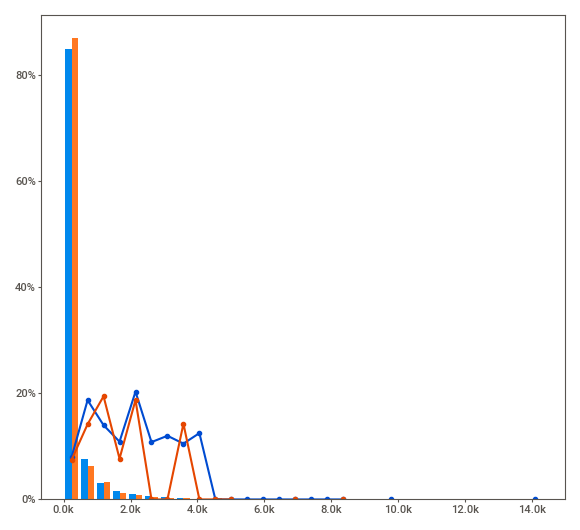
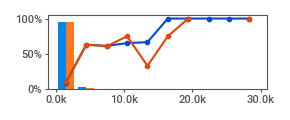
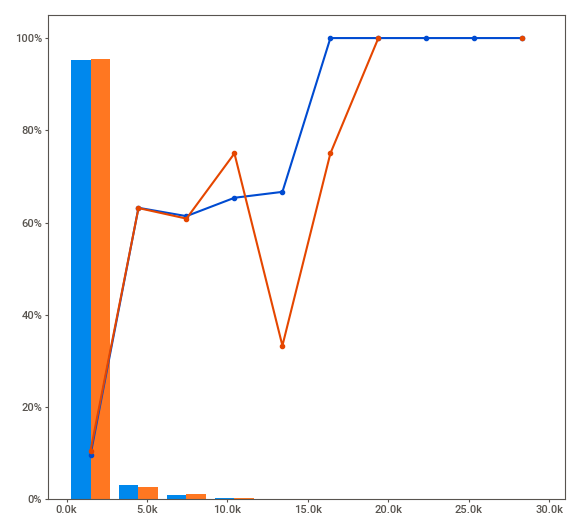
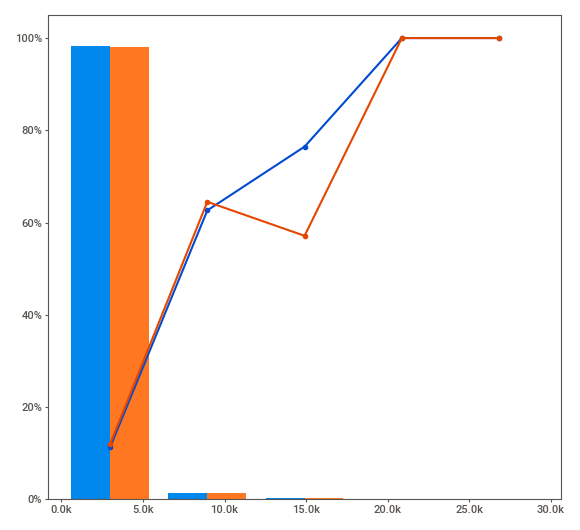
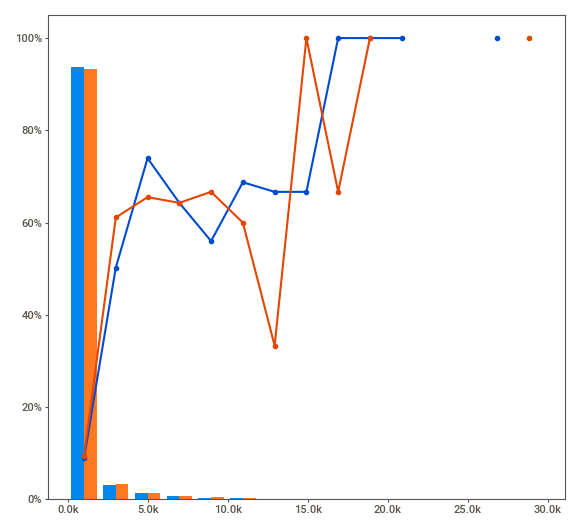
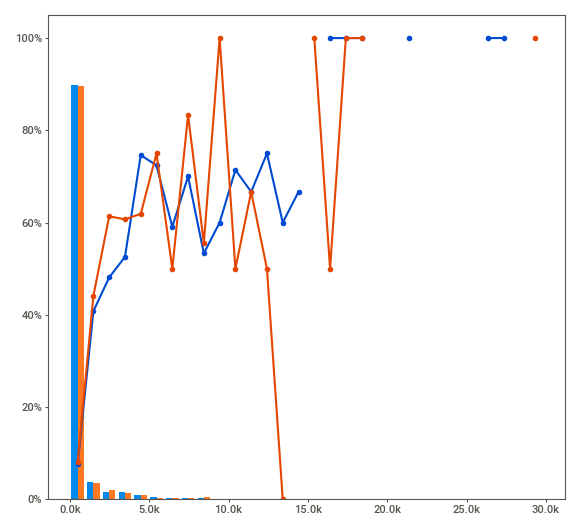
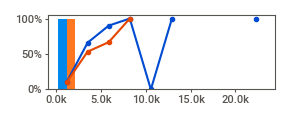
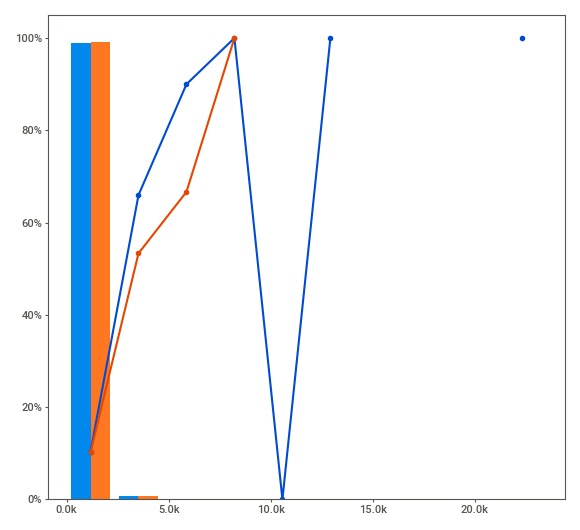
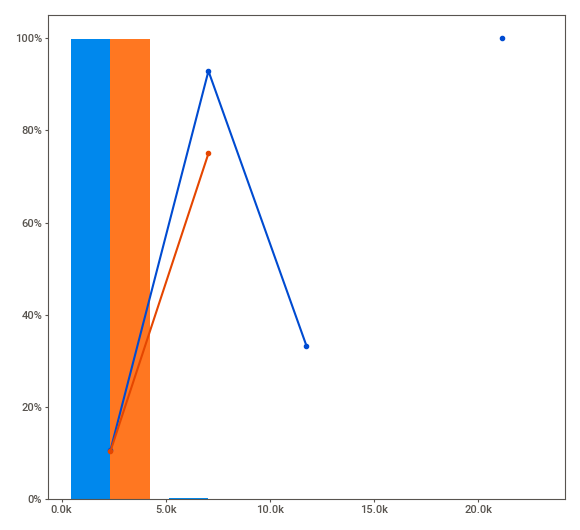
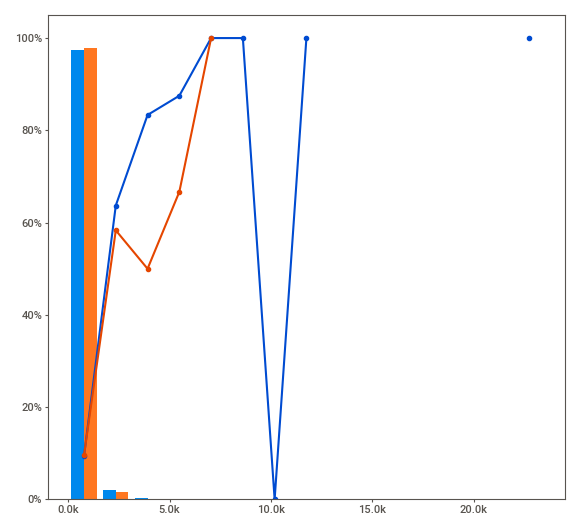
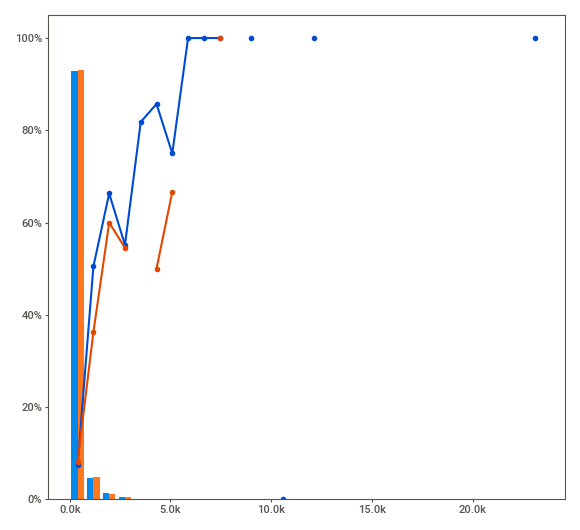
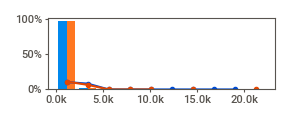
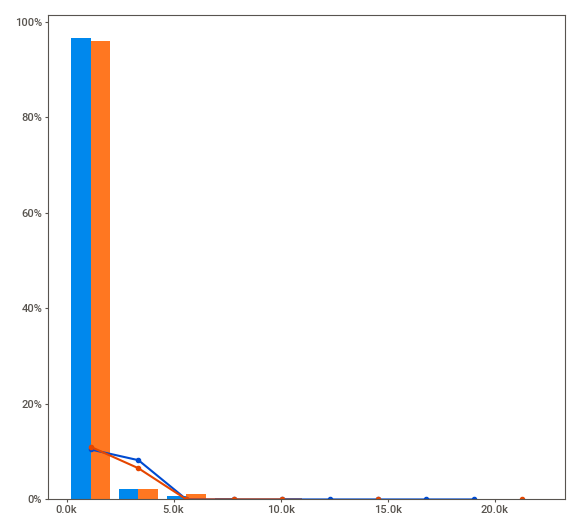
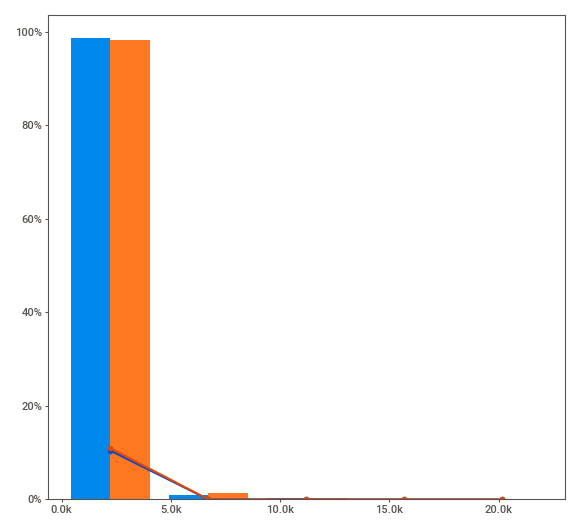
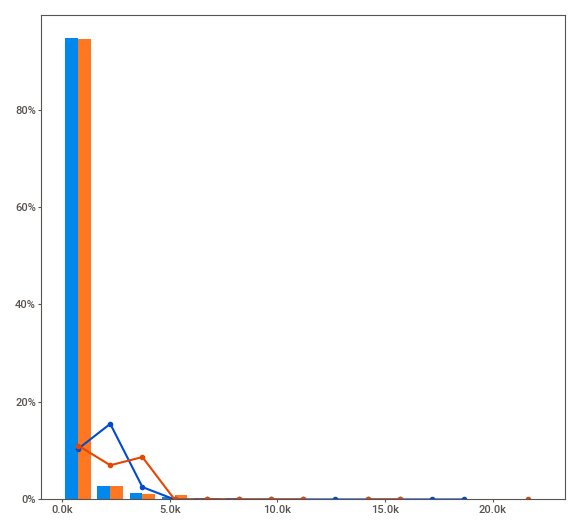
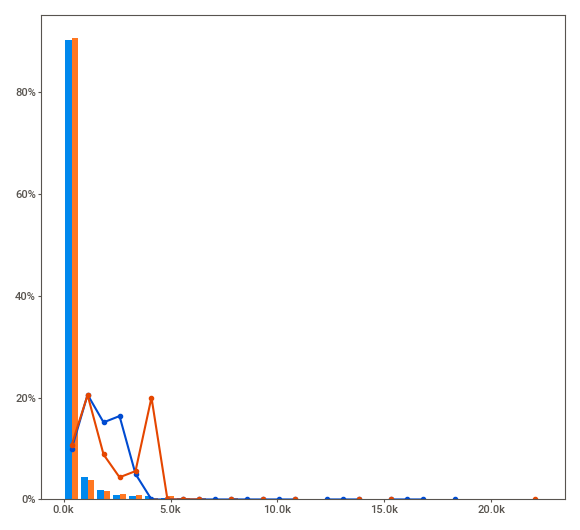
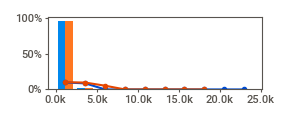
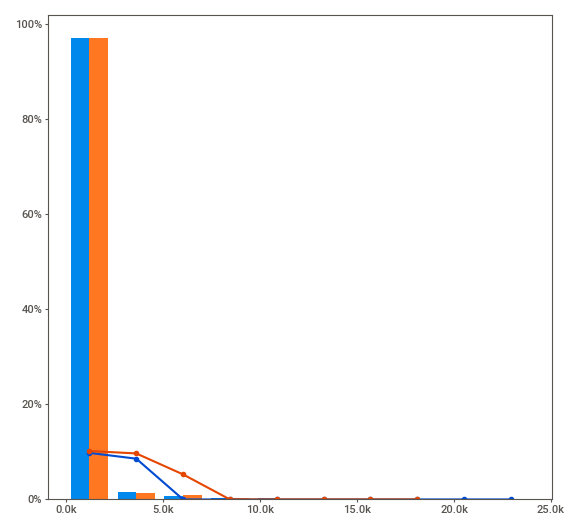
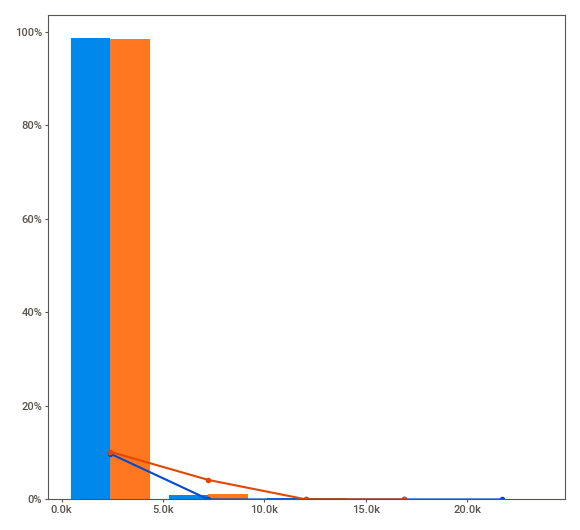
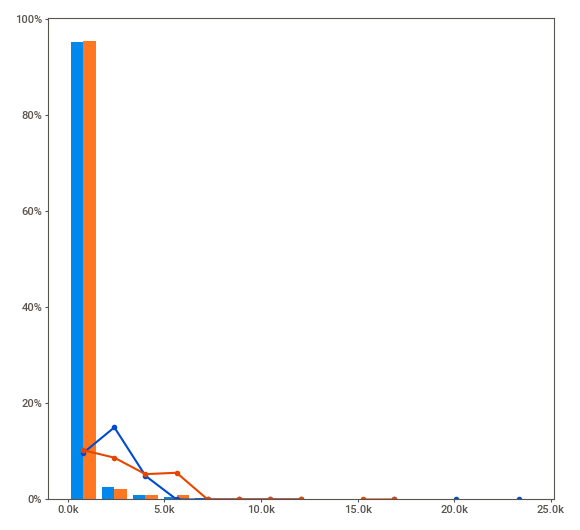
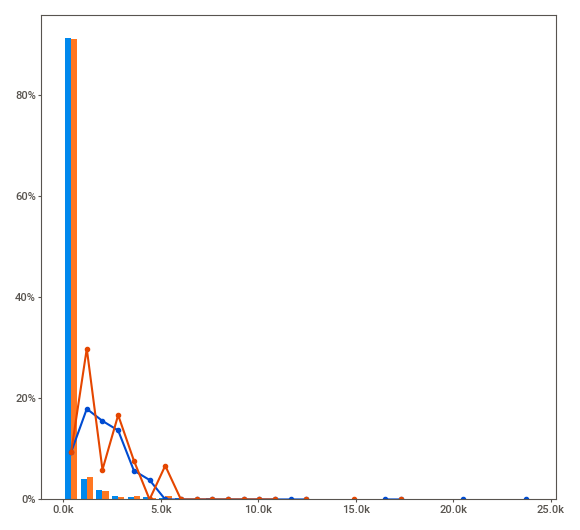
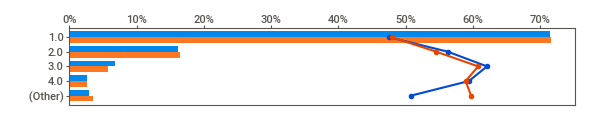
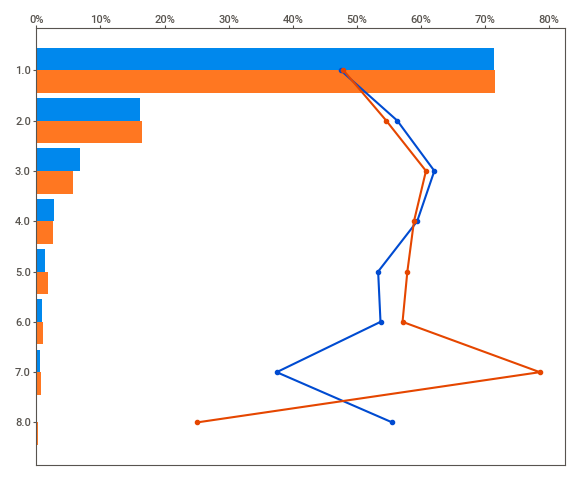
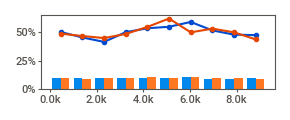
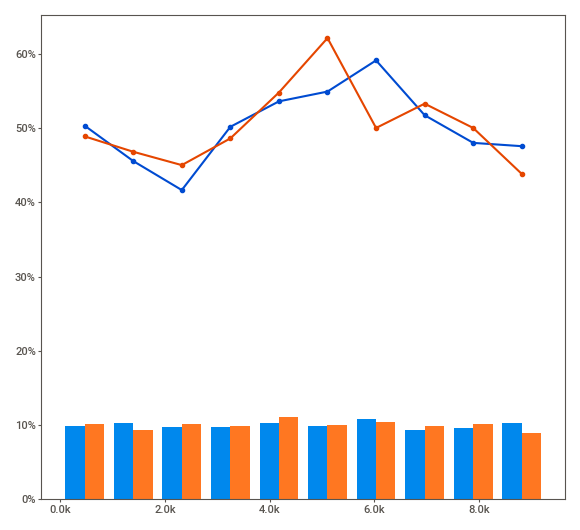
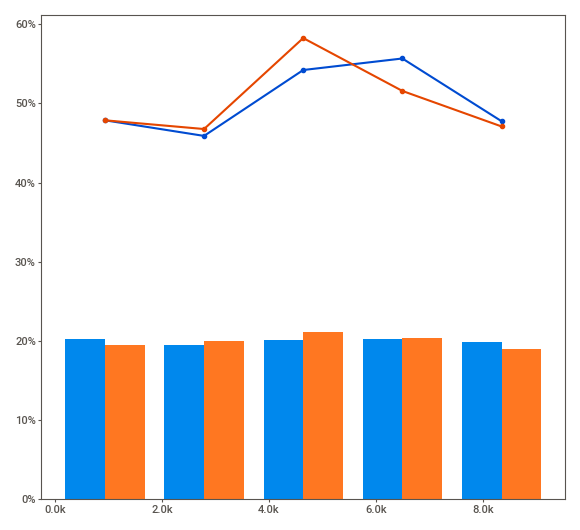
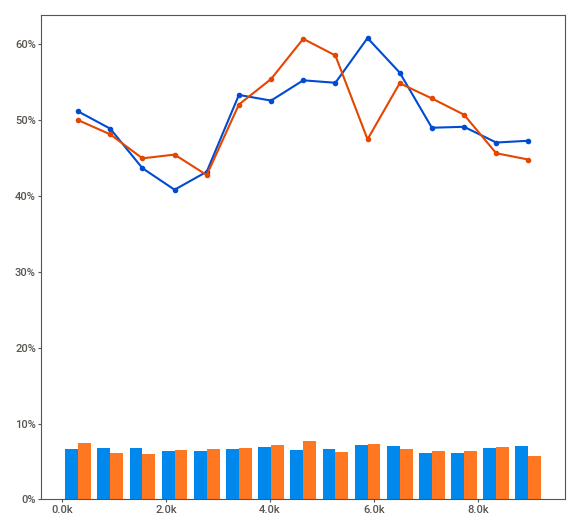
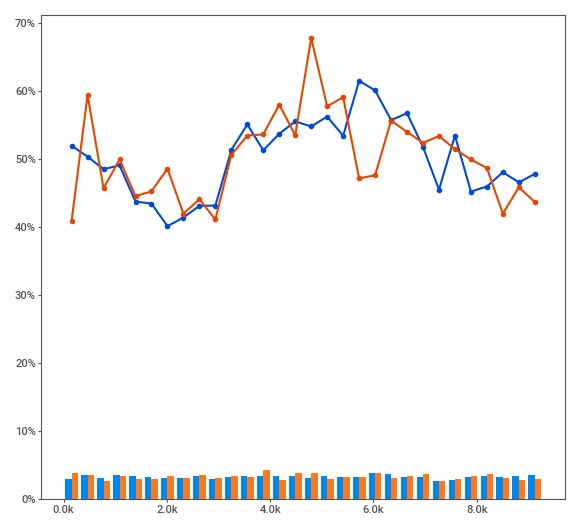
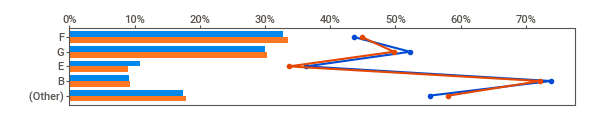
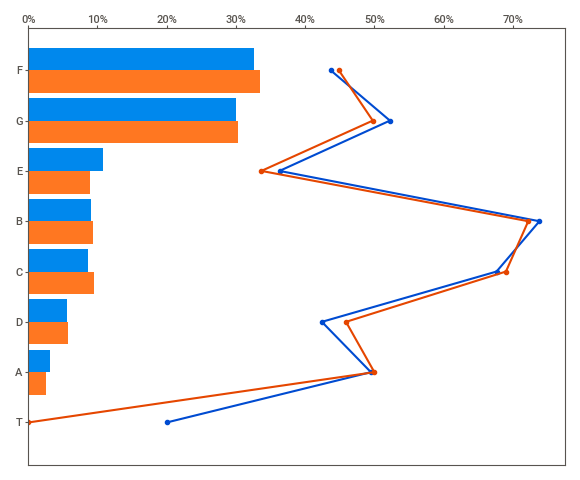
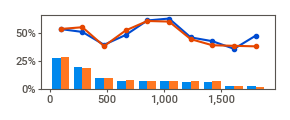
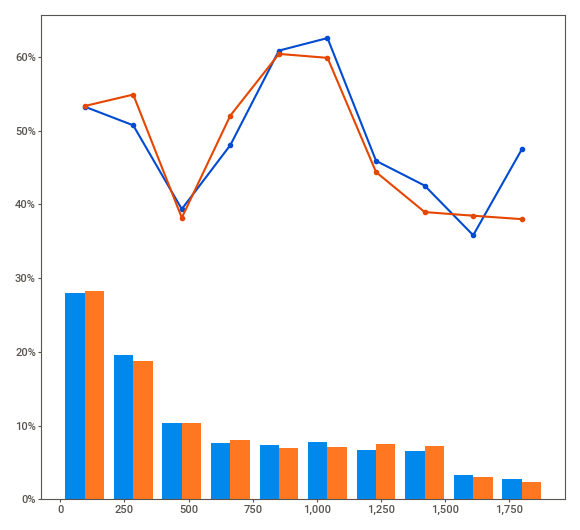
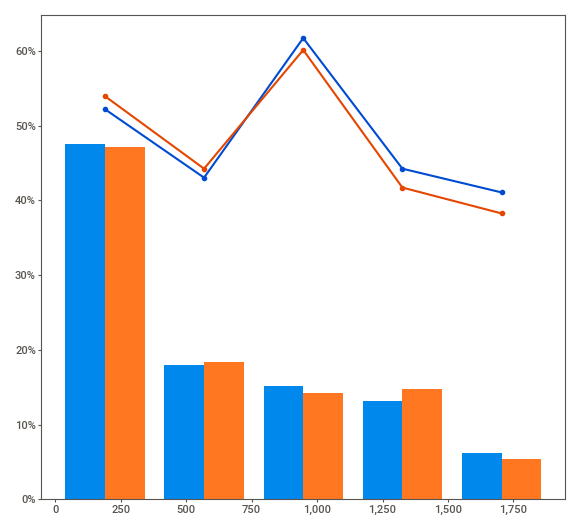
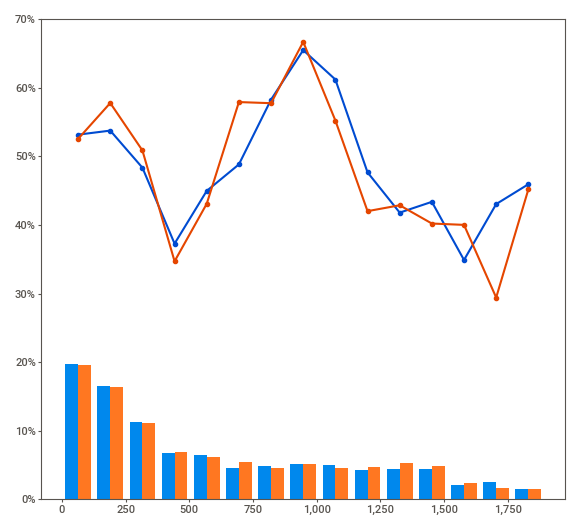
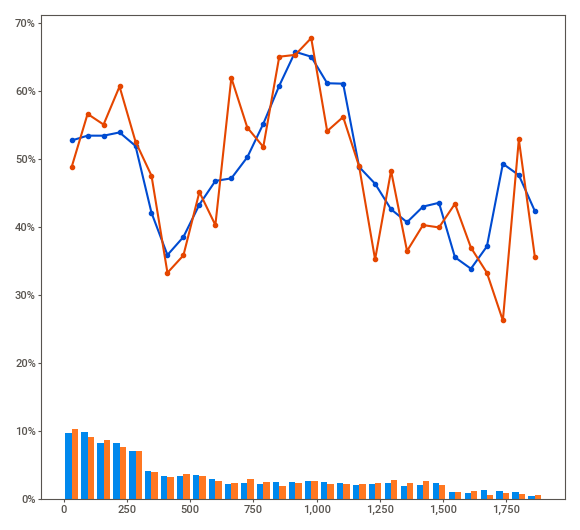
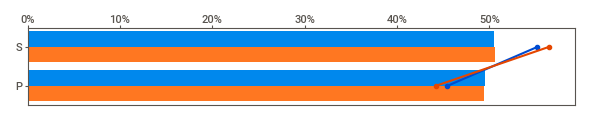
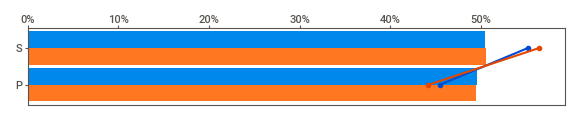
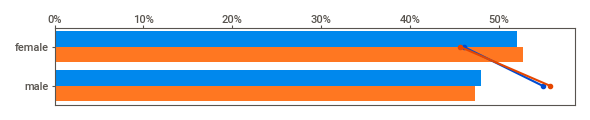
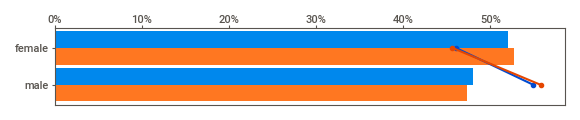
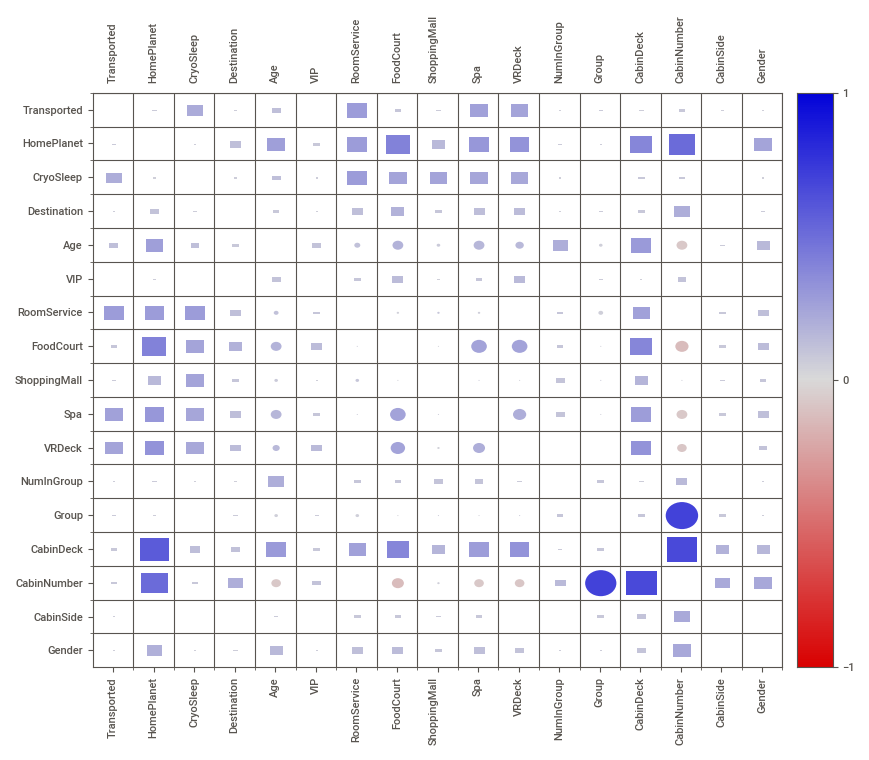
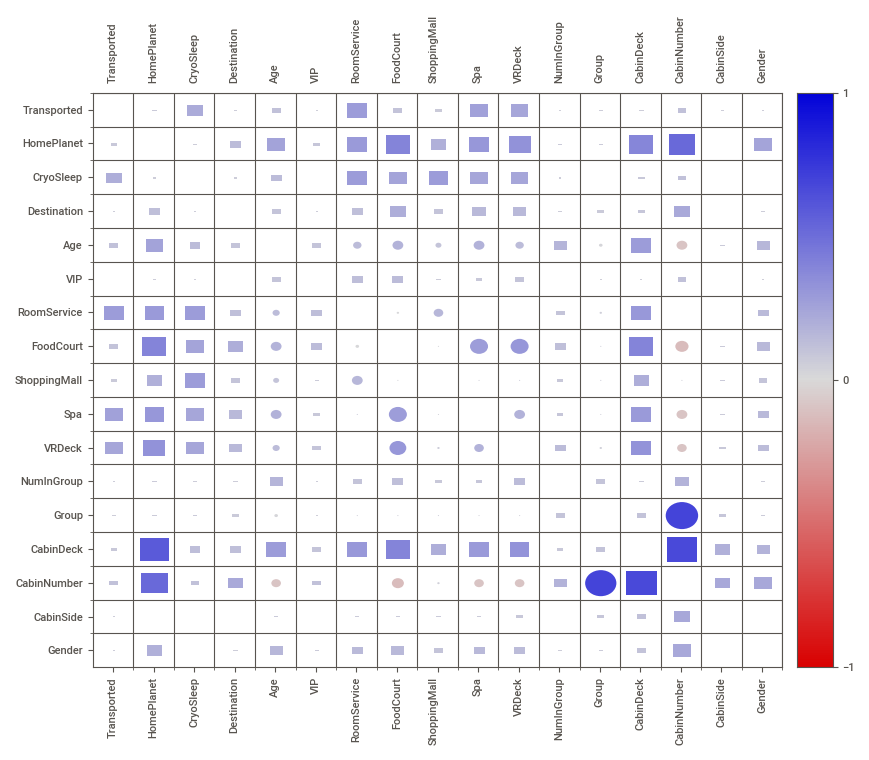

Report 'Report.html' was saved to storage.


In [14]:
#Generamos el html para poderlo visualizar por aparte
my_report.show_html(
    scale=None, #valor entre 0 y 1
    layout='vertical', #vertical es mucho mejor para dispositivos con pantallas pequeñas
    filepath='Report_viewable.html')
#Ahora podemos hacer lo mismo para verlo directamente en el notebook
my_report.show_notebook(
    w=None, #Ancho en pixeles o en porcentajes
    h=None, #Altura en pixeles o en porcentajes
    scale=None, #valor entre 0 y 1
    #layout='vertical', #vertical es mucho mejor para dispositivos con pantallas pequeñas
    filepath='Report.html')

## ¿Qué podemos decir acerca de estos resultados?

A priori, nos gustaría que tanto los datos de entrenamiento, como los de validación tuvieran un comportamiento similar, pues la muestra fue extraida aleatoriamente. En caso de no ser así, podríamos estar en presencia de datos atípico que no deben ser tomados en cuenta.

Según el informe de Sweetviz, una de las características que más influye en el comportamiento de la variable objetivo es `CryoSleep`, mostrándonos que alrededor del 80% de las personas que fueron puestas en sueño criogénico para el viaje fueron transportadas a otra dimensión, lo que contrasta con la situación para las personas que viajaron normalmente, pues solo el 33% de ellas fueron transportadas. `CabinDeck`, `HomePlanet` y `Destination` también son otras de las características categóricas que influyen en `Transported`, pero su aporte es mucho más pequeño. 
Con respecto a las características numéricas, se observa que las más destacadas son 3 relacionadas con los servicios de lujo ofrecidos por la nave. Estas son `RoomService`, `Spa` y `VRDeck`, con más de un 0.2 en su coeficiente de relación. También se puede ver que la edad tiene cierta influencia, pero mucha menos que las anteriores. Así pues, pese a su poca influencia, también vale la pena contarlas para el análisis, así como a `FoodCourt`, `CabinNumber`, `Group` y `ShoppingMall`.

Lo ideal ahora sería probar algún modelo y ver como se comporta con las características *originales*. Para ello vamos a definir qué hacer en el caso de los datos faltantes. Probemos autocompletarlos usando los valores *Desconocido* para las características categóricas, -1 para las booleanas y la mediana para las puramente numéricas.

In [11]:
#Definimos las características categoricas que queremos transformar con la codificación OneHot
categorical_oh_features= ["HomePlanet","Destination","CabinDeck",'CabinSide','Gender']
categorical_oh_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")), #Podemos usar la estrategia de imputar con el más frecuente
    ("imputer", SimpleImputer(strategy='constant',fill_value='Unknown')),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

boolean_feature = ["VIP","CryoSleep"]
boolean_transformer = Pipeline (steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),
    ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
    #("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])



#Definimos las características numéricas que vamos a tratar
luxury_features = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
luxury_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ])

numeric_features = ['Age', 'Group','CabinNumber','NumInGroup']
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant",fill_value=-1)),
    ])

# Ajustar los pasos de preprocesamiento: llenar los valores faltantes y luego convertir todos los datos a números
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("lux", luxury_transformer, luxury_features),
    ("cat", categorical_oh_transformer, categorical_oh_features),
    ("bool", boolean_transformer, boolean_feature),
    ])

models = {
        #"KNN": KNeighborsClassifier(),
        "Logistic Regression": LogisticRegression(), 
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "CatBoostClassifier": CatBoostClassifier(),
         }

# Creamos una función para ajustar y puntuar los modelos
def fit_and_score(models, X_train, X_test, y_train, y_test,random_state=0):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(random_state)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        modelaux=Pipeline(steps=[("preprocessor", preprocessor),
                        ("model", model)])
        # Fit the model to the data
        modelaux.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = modelaux.score(X_test, y_test)
    return model_scores

In [12]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_valid,
                             y_train=y_train,
                             y_test=y_valid, random_state=0)
model_scores

D:\DataScience\Spacial_titanic_project\env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.02294
0:	learn: 0.6810364	total: 203ms	remaining: 3m 22s
1:	learn: 0.6715305	total: 206ms	remaining: 1m 42s
2:	learn: 0.6612923	total: 209ms	remaining: 1m 9s
3:	learn: 0.6524908	total: 212ms	remaining: 52.7s
4:	learn: 0.6440375	total: 214ms	remaining: 42.7s
5:	learn: 0.6357267	total: 217ms	remaining: 36s
6:	learn: 0.6275994	total: 220ms	remaining: 31.1s
7:	learn: 0.6198062	total: 223ms	remaining: 27.6s
8:	learn: 0.6126778	total: 225ms	remaining: 24.8s
9:	learn: 0.6061503	total: 228ms	remaining: 22.6s
10:	learn: 0.6006170	total: 231ms	remaining: 20.7s
11:	learn: 0.5940517	total: 233ms	remaining: 19.2s
12:	learn: 0.5883680	total: 236ms	remaining: 17.9s
13:	learn: 0.5827908	total: 238ms	remaining: 16.8s
14:	learn: 0.5769969	total: 241ms	remaining: 15.8s
15:	learn: 0.5707091	total: 243ms	remaining: 15s
16:	learn: 0.5659756	total: 246ms	remaining: 14.2s
17:	learn: 0.5621761	total: 249ms	remaining: 13.6s
18:	learn: 0.5582231	total: 251ms	remaining: 13s
19:	learn: 0.554

187:	learn: 0.3917419	total: 718ms	remaining: 3.1s
188:	learn: 0.3914172	total: 722ms	remaining: 3.1s
189:	learn: 0.3911443	total: 725ms	remaining: 3.09s
190:	learn: 0.3908332	total: 728ms	remaining: 3.08s
191:	learn: 0.3906096	total: 732ms	remaining: 3.08s
192:	learn: 0.3904515	total: 735ms	remaining: 3.07s
193:	learn: 0.3900440	total: 738ms	remaining: 3.06s
194:	learn: 0.3897360	total: 740ms	remaining: 3.06s
195:	learn: 0.3894758	total: 743ms	remaining: 3.05s
196:	learn: 0.3891944	total: 746ms	remaining: 3.04s
197:	learn: 0.3889710	total: 749ms	remaining: 3.03s
198:	learn: 0.3887713	total: 752ms	remaining: 3.02s
199:	learn: 0.3886037	total: 754ms	remaining: 3.02s
200:	learn: 0.3883292	total: 757ms	remaining: 3.01s
201:	learn: 0.3881774	total: 760ms	remaining: 3s
202:	learn: 0.3879422	total: 762ms	remaining: 2.99s
203:	learn: 0.3876898	total: 765ms	remaining: 2.98s
204:	learn: 0.3874768	total: 768ms	remaining: 2.98s
205:	learn: 0.3872514	total: 770ms	remaining: 2.97s
206:	learn: 0.386

375:	learn: 0.3551136	total: 1.24s	remaining: 2.06s
376:	learn: 0.3548901	total: 1.25s	remaining: 2.06s
377:	learn: 0.3547013	total: 1.25s	remaining: 2.05s
378:	learn: 0.3545807	total: 1.25s	remaining: 2.05s
379:	learn: 0.3544349	total: 1.25s	remaining: 2.05s
380:	learn: 0.3543185	total: 1.26s	remaining: 2.04s
381:	learn: 0.3541211	total: 1.26s	remaining: 2.04s
382:	learn: 0.3540001	total: 1.26s	remaining: 2.04s
383:	learn: 0.3539023	total: 1.27s	remaining: 2.03s
384:	learn: 0.3538099	total: 1.27s	remaining: 2.03s
385:	learn: 0.3536656	total: 1.27s	remaining: 2.02s
386:	learn: 0.3535621	total: 1.27s	remaining: 2.02s
387:	learn: 0.3534261	total: 1.28s	remaining: 2.02s
388:	learn: 0.3532997	total: 1.28s	remaining: 2.01s
389:	learn: 0.3530346	total: 1.28s	remaining: 2.01s
390:	learn: 0.3528910	total: 1.28s	remaining: 2s
391:	learn: 0.3527744	total: 1.29s	remaining: 2s
392:	learn: 0.3526150	total: 1.29s	remaining: 1.99s
393:	learn: 0.3524960	total: 1.29s	remaining: 1.99s
394:	learn: 0.3523

568:	learn: 0.3273243	total: 1.77s	remaining: 1.34s
569:	learn: 0.3271381	total: 1.77s	remaining: 1.33s
570:	learn: 0.3269416	total: 1.77s	remaining: 1.33s
571:	learn: 0.3268466	total: 1.78s	remaining: 1.33s
572:	learn: 0.3267161	total: 1.78s	remaining: 1.33s
573:	learn: 0.3265006	total: 1.78s	remaining: 1.32s
574:	learn: 0.3263420	total: 1.79s	remaining: 1.32s
575:	learn: 0.3262329	total: 1.79s	remaining: 1.32s
576:	learn: 0.3260309	total: 1.79s	remaining: 1.31s
577:	learn: 0.3259231	total: 1.79s	remaining: 1.31s
578:	learn: 0.3258281	total: 1.8s	remaining: 1.31s
579:	learn: 0.3257118	total: 1.8s	remaining: 1.3s
580:	learn: 0.3255953	total: 1.8s	remaining: 1.3s
581:	learn: 0.3255119	total: 1.81s	remaining: 1.3s
582:	learn: 0.3253987	total: 1.81s	remaining: 1.29s
583:	learn: 0.3252799	total: 1.81s	remaining: 1.29s
584:	learn: 0.3251626	total: 1.81s	remaining: 1.29s
585:	learn: 0.3250649	total: 1.82s	remaining: 1.28s
586:	learn: 0.3249627	total: 1.82s	remaining: 1.28s
587:	learn: 0.3248

753:	learn: 0.3049417	total: 2.29s	remaining: 747ms
754:	learn: 0.3048711	total: 2.29s	remaining: 744ms
755:	learn: 0.3047766	total: 2.29s	remaining: 741ms
756:	learn: 0.3045080	total: 2.3s	remaining: 738ms
757:	learn: 0.3044440	total: 2.3s	remaining: 735ms
758:	learn: 0.3043107	total: 2.31s	remaining: 732ms
759:	learn: 0.3042067	total: 2.31s	remaining: 729ms
760:	learn: 0.3041432	total: 2.31s	remaining: 726ms
761:	learn: 0.3040454	total: 2.31s	remaining: 723ms
762:	learn: 0.3039225	total: 2.32s	remaining: 720ms
763:	learn: 0.3038209	total: 2.32s	remaining: 717ms
764:	learn: 0.3036966	total: 2.32s	remaining: 714ms
765:	learn: 0.3035668	total: 2.33s	remaining: 711ms
766:	learn: 0.3034715	total: 2.33s	remaining: 708ms
767:	learn: 0.3033688	total: 2.33s	remaining: 705ms
768:	learn: 0.3033206	total: 2.34s	remaining: 702ms
769:	learn: 0.3032300	total: 2.34s	remaining: 699ms
770:	learn: 0.3031713	total: 2.34s	remaining: 696ms
771:	learn: 0.3030587	total: 2.35s	remaining: 693ms
772:	learn: 0.

922:	learn: 0.2868228	total: 2.81s	remaining: 235ms
923:	learn: 0.2866966	total: 2.82s	remaining: 232ms
924:	learn: 0.2865597	total: 2.82s	remaining: 229ms
925:	learn: 0.2865481	total: 2.82s	remaining: 226ms
926:	learn: 0.2864481	total: 2.82s	remaining: 222ms
927:	learn: 0.2862907	total: 2.83s	remaining: 220ms
928:	learn: 0.2861454	total: 2.83s	remaining: 216ms
929:	learn: 0.2860892	total: 2.83s	remaining: 213ms
930:	learn: 0.2860162	total: 2.84s	remaining: 210ms
931:	learn: 0.2859259	total: 2.84s	remaining: 207ms
932:	learn: 0.2858859	total: 2.85s	remaining: 204ms
933:	learn: 0.2857800	total: 2.85s	remaining: 201ms
934:	learn: 0.2856017	total: 2.85s	remaining: 198ms
935:	learn: 0.2855231	total: 2.85s	remaining: 195ms
936:	learn: 0.2854362	total: 2.86s	remaining: 192ms
937:	learn: 0.2853331	total: 2.86s	remaining: 189ms
938:	learn: 0.2852347	total: 2.86s	remaining: 186ms
939:	learn: 0.2850893	total: 2.87s	remaining: 183ms
940:	learn: 0.2850197	total: 2.87s	remaining: 180ms
941:	learn: 

CatBoostError: predicted classes have string type but specified y is boolean

¡Genial! Obtuvimos una exactitud más del 0.8, que es nuestra meta. Pero debemos recordar que para lo hecho anteriormente fijamos una semilla (0) y que los resultados podrían estar sesgados. La idea ahora es realizar validación cruzada; escojamos por ejemplo el modelo de Gradient Boosting (lástimosamente todavía no sé como hacer cv con catboost). En este caso se suelen usar todos los datos de entrenamiento.

In [292]:
X_train_cv=transformacion_inicial_datos(train)
y_train_cv=X_train_cv.pop('Transported')
#X_train_cv=preprocessor.fit_transform(X_train_cv,y_train_cv)
#cat_names= list(preprocessor.transformers_[2][1].named_steps['onehot'].get_feature_names_out(categorical_oh_features))
#X_train_cv=pd.DataFrame(X_train_cv,columns=numeric_features+luxury_features+cat_names+boolean_feature)

#X_train_cv[cat_names+boolean_feature]=X_train_cv[cat_names+boolean_feature].astype('int64')

gbc_model = Pipeline(steps=[
    ('prep',preprocessor),
    ('model',GradientBoostingClassifier()),
])
scores = cross_val_score(gbc_model,X_train_cv,y_train_cv, cv=50)
print(scores.mean())


0.7938548933625672


Como podemos observar, ahora el puntaje bajó, y es lo normal, porque los modelos tienden a acomodarse particularmente a los datos que le damos. Si usamos un parámetro de cv muy bajito, obtendremos valores muy pequeños.

In [281]:
gbc_model.fit(X_train_cv,y_train_cv)
fi=gbc_model.named_steps["model"].feature_importances_
features_dict = dict(zip(X_train_cv.columns, list(fi)))
features_dict

{'Age': 0.0194541860699579,
 'Group': 0.020553855047540977,
 'CabinNumber': 0.037566616760185405,
 'NumInGroup': 0.00025660245557416035,
 'RoomService': 0.09643815191894203,
 'FoodCourt': 0.06257275769390033,
 'ShoppingMall': 0.030405857464365,
 'Spa': 0.13166466100000643,
 'VRDeck': 0.11105116179466834,
 'HomePlanet_Earth': 0.06257568374404081,
 'HomePlanet_Europa': 0.02552433172659556,
 'HomePlanet_Mars': 0.007379032506550392,
 'HomePlanet_Unknown': 0.0002770952219811496,
 'Destination_55 Cancri e': 0.0031006543146616466,
 'Destination_PSO J318.5-22': 0.0007314045982738975,
 'Destination_TRAPPIST-1e': 0.0024138118082180837,
 'Destination_Unknown': 0.0,
 'CabinDeck_A': 0.00046914371635349713,
 'CabinDeck_B': 0.0003670081392061575,
 'CabinDeck_C': 0.006117366758803813,
 'CabinDeck_D': 0.0,
 'CabinDeck_E': 0.01406637009249654,
 'CabinDeck_F': 0.002393442814275963,
 'CabinDeck_G': 0.0066244396324359476,
 'CabinDeck_T': 0.0,
 'CabinDeck_Unknown': 0.0,
 'CabinSide_P': 0.002282888488114868,

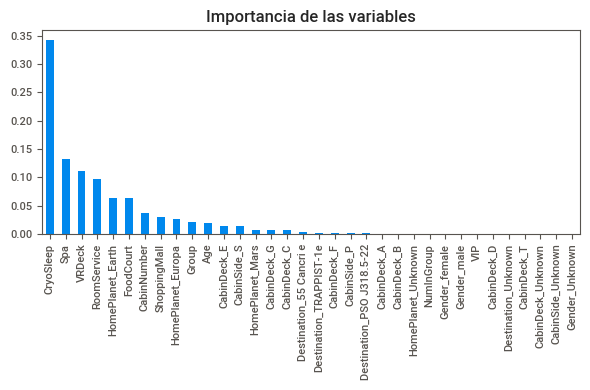

In [282]:
features_df = pd.DataFrame(features_dict, index=[0]).T.sort_values(by=[0], ascending=False).T
features_df.T.plot.bar(title="Importancia de las variables", legend=False);

Podemos ver que el la importancia de cada parámetro del modelo concuerda con el análisis que hicimos anteriormente, por lo que podríamos decir que este modelo representa muy bien lo que queremos.

Por último veamos lo que nos dice la información mutua acerca de las características.

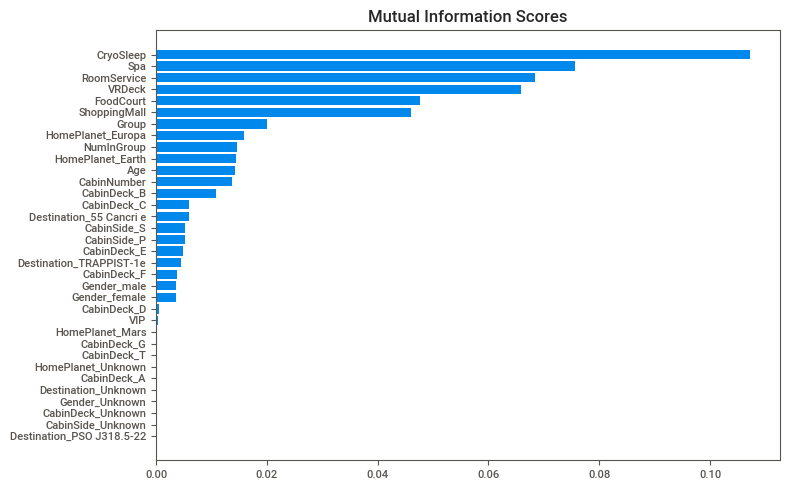

In [283]:
mi_scores=make_mi_scores_classification(X_train_cv,y_train_cv)
plot_mi_scores(mi_scores)

Encontramos algo muy similar a lo observado en la importancia de las características obtenidas por el modelo y lo realizado en el análisis del reporte de Sweetviz. Tenemos entonces otra manera de soportar nuestros resultados.

In [301]:
gbc_model.fit(train2.drop(['Transported'],axis=1),train2['Transported'])
submit=pd.DataFrame()
submit["PassengerId"]=test.PassengerId
submit["Transported"]=pd.Series(gbc_model.predict(transformacion_inicial_datos(test))).apply(lambda x: x==1)
submit
submit.to_csv('submit.csv', index=False)

¡Genial! Obtuvimos el puesto 403 y nuestro modelo superó el puntaje que nos establecimos como meta.
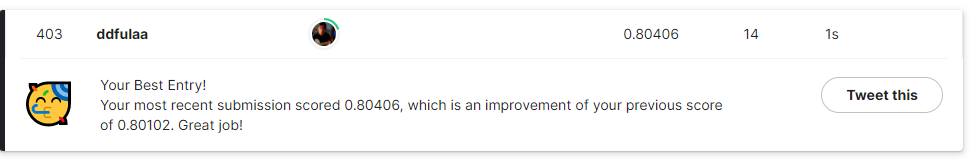

La cuestión ahora es ¿cómo podemos hacerlo mejor?¿Será que si le hacemos ajustes a las características obtendremos un mejor resultado? ¿Debimos hacer un EDA más profundo para encontrar patrones en los datos?¿Basta con simplemente rellenar los datos faltantes con los datos que queramos o hay otra manera de hacerlo?¿Hay patrones en los datos que no hemos explotado lo suficientemente bien? ¿Deberíamos optimizar el modelo ajustando los hiperparámetros?

---